In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from Bio import Phylo
import io
from tqdm import tqdm

In [2]:
# fmt: off
value_to_base = [
    "AA", "CC", "GG", "TT",
    "AC", "AG", "AT", "CG",
    "CT", "GT", "CA", "GA",
    "TA", "GC", "TC", "TG",
]
# fmt: on


class Node:
    def __init__(self, value: np.ndarray, parent: "Node | None"):
        """
        value: length N array of ints
        """

        self.name = ""
        self.value = value
        self.parent = parent

        # will be populated with only the non-pruned nodes in the tree
        self.children = set[Node]()

    def set_name(self, name: str):
        self.name = name

    def set_value(self, value: np.ndarray):
        self.value = value

    def add_child(self, child: "Node"):
        self.children.add(child)

    def add_child_up_to_root(self):
        """
        Populates the children field for all nodes up to the root
        """

        if self.parent:
            self.parent.add_child(self)
            self.parent.add_child_up_to_root()

    def get_human_readable_value(self):
        return "|".join([value_to_base[v] for v in self.value])

    def get_phy_value(self, human_readable=False):
        # fmt: off
        value_to_base = [
            "A", "C", "G", "T",
            # represent as unphased
            "M", "R", "W", "S", "Y", "K",
            "M", "R", "W", "S", "Y", "K",
        ]
        # fmt: on

        return "".join([value_to_base[v] for v in self.value])

    def get_newick_tree(self) -> str:
        if len(self.children) == 0:
            return self.name
        else:
            return f"({','.join([child.get_newick_tree() for child in self.children])}){self.name}"


class Cell_Reader:
    def __init__(self, delta: float, epsilon: float):
        """
        delta: ADO rate
        epsilon: ERR rate
        """

        self.delta = delta
        self.epsilon = epsilon

    def read_cell(self, cell: Node) -> Node:
        def mutate_site(site_value: int):
            # in CellPhy model, ERR is applied before ADO

            b1, b2 = value_to_base[site_value]

            if np.random.rand() < self.epsilon:  # ERR
                # 50-50 chance of mutating either base
                if np.random.rand() < 0.5:
                    b1 = np.random.choice([b for b in "ACGT" if b != b1])
                else:
                    b2 = np.random.choice([b for b in "ACGT" if b != b2])

            if np.random.rand() < self.delta:  # ADO
                # 50-50 chance of dropping either base
                if np.random.rand() < 0.5:
                    b1 = b2
                else:
                    b2 = b1

            new_site_value = value_to_base.index(b1 + b2)
            return new_site_value

        new_value = np.array([mutate_site(site_value) for site_value in cell.value])
        cell.set_value(new_value)
        return cell


class Simulate_GT16:
    def __init__(
        self,
        cell_reader: Cell_Reader,
        exchangeability: np.ndarray,
        stationary: np.ndarray,
        *,
        N=500,
        pool_size=20,
        final_leaf_count=20,
        child_sample_count=10,
        dt=1,
        sim_steps=10,
    ):
        """
        exchangeability: length 6
        stationary: length 16
        N: number of sites
        """

        self.cell_reader = cell_reader
        self.pi = exchangeability
        self.stat = stationary
        self.N = N
        self.pool_size = pool_size
        self.final_leaf_count = final_leaf_count
        self.child_sample_count = child_sample_count
        self.dt = dt
        self.sim_steps = sim_steps

        self.A = 16

        self.Q = self.get_Q()
        self.plot_Q()

        self.dummy_root_cell, self.healthy_cell, self.leaf_cells = self.simulate()
        self.newick_tree = self.get_newick_tree()

    def get_Q(self):
        pi8 = np.repeat(self.pi, 8)

        # index helpers for Q matrix
        AA, CC, GG, TT, AC, AG, AT, CG, CT, GT, CA, GA, TA, GC, TC, TG = range(self.A)

        # fmt: off
        updates = [
          # | first base changes                    | second base changes
            [AA, CA], [AC, CC], [AG, CG], [AT, CT], [AA, AC], [CA, CC], [GA, GC], [TA, TC], # A->C
            [AA, GA], [AC, GC], [AG, GG], [AT, GT], [AA, AG], [CA, CG], [GA, GG], [TA, TG], # A->G
            [AA, TA], [AC, TC], [AG, TG], [AT, TT], [AA, AT], [CA, CT], [GA, GT], [TA, TT], # A->T
            [CA, GA], [CC, GC], [CG, GG], [CT, GT], [AC, AG], [CC, CG], [GC, GG], [TC, TG], # C->G
            [CA, TA], [CC, TC], [CG, TG], [CT, TT], [AC, AT], [CC, CT], [GC, GT], [TC, TT], # C->T
            [GA, TA], [GC, TC], [GG, TG], [GT, TT], [AG, AT], [CG, CT], [GG, GT], [TG, TT], # G->T
        ]
        # fmt: on

        R = np.zeros((self.A, self.A))

        for update, pi_val in zip(updates, pi8):
            R[update[0], update[1]] = pi_val

        R = R + R.T

        y_q = R @ np.diag(self.stat)
        hyphens = np.sum(y_q, axis=1)
        Q = np.copy(y_q)
        np.fill_diagonal(Q, -hyphens)
        return Q

    def plot_Q(self):
        plt.title("Q matrix used for simulation")
        plt.imshow(self.Q)
        plt.show()

    def sample(self, probabilities: np.ndarray):
        """
        probabilities: length A
        """

        normalized_probabilities = probabilities / np.sum(probabilities)
        return np.random.choice(self.A, p=normalized_probabilities)

    def probabilities_to_cell(self, probabilities: np.ndarray, parent: Node | None):
        """
        probabilities: N x A
        """

        sampled_value = np.apply_along_axis(self.sample, 1, probabilities)
        return Node(sampled_value, parent)

    def evolve_cell(self, cell: Node):
        # expand length N array cell.value into N x A array of one-hot vectors
        value_one_hot = np.eye(self.A)[cell.value]

        probabilities = scipy.linalg.expm(self.Q * self.dt) @ value_one_hot.T  # A x N
        probabilities = probabilities.T  # N x A
        return self.probabilities_to_cell(probabilities, cell)

    def simulate(self) -> tuple[Node, Node, list[Node]]:
        probabilities_across_sites = np.tile(self.stat, (self.N, 1))

        dummy_root_cell = Node(np.zeros(self.N, dtype=int), None)

        pool = [
            self.probabilities_to_cell(probabilities_across_sites, dummy_root_cell)
            for _ in range(self.pool_size)
        ]

        healthy_cell = pool[0]

        for _ in tqdm(range(self.sim_steps)):
            new_pool = []

            for cell in pool:
                for _ in range(self.child_sample_count):
                    new_pool.append(self.evolve_cell(cell))

            pool = np.random.choice(new_pool, size=self.pool_size, replace=False)

        leaf_cells = np.random.choice(pool, size=self.final_leaf_count, replace=False)  # type: ignore
        leaf_cells = [self.cell_reader.read_cell(cell) for cell in leaf_cells]

        dummy_root_cell.set_name("Dummy")
        healthy_cell.set_name("Healthy")

        for i, cell in enumerate(leaf_cells):
            cell.set_name(f"CELL-{i}")

        return dummy_root_cell, healthy_cell, leaf_cells

    def get_newick_tree(self) -> str:
        # add relevant children to each node
        for cell in [self.healthy_cell] + self.leaf_cells:
            cell.add_child_up_to_root()

        return self.dummy_root_cell.get_newick_tree()

    def save_to_dot_phy(self, path: str):
        total_cells = self.final_leaf_count + 1  # including healthy cell

        with open(path, "w") as f:
            f.write(f"{total_cells} {self.N}\n")

            for cell in [self.healthy_cell] + self.leaf_cells:
                f.write(f"{cell.name}    {cell.get_phy_value()}\n")

exchangeability (normalized): [0.16324978 0.19230266 0.12806624 0.21378274 0.14131846 0.16128012]
stationary (normalized): [0.08201722 0.06237363 0.06112082 0.04901926 0.04571451 0.07950737
 0.05510672 0.07930659 0.06250263 0.06112642 0.05892818 0.05520572
 0.05984322 0.06536363 0.07905864 0.04380544]


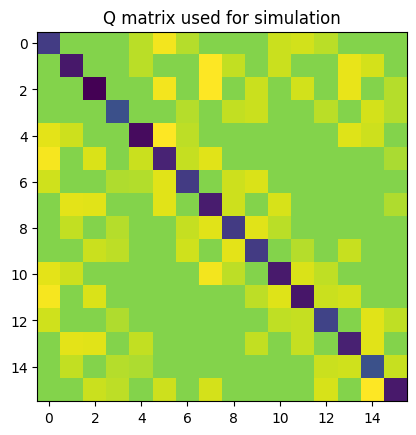

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Newick tree: (((((((((((CELL-0,CELL-15),(CELL-1)))))),((((((CELL-6,CELL-17,CELL-7),(CELL-8)),((CELL-14,CELL-16))))))))))Healthy,((((((((((CELL-5),(CELL-10,CELL-13)))))))))),((((((((((CELL-9),(CELL-12)))))))))),((((((((((CELL-19),(CELL-2))),(((CELL-18)),((CELL-3,CELL-4))))))),(((((((CELL-11)))))))))))Dummy


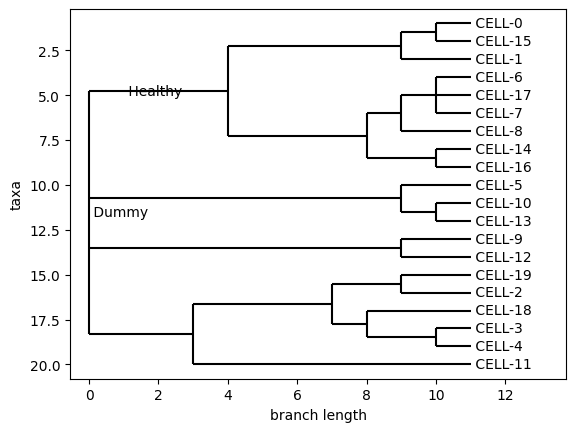

Saved to ./data/cellphy_simulated_set.phy
CG|GA|TC|GG|AG|GT|CG|AT|CA|CC|TA|CT|TC|CA|CG|CG|GA|CG|TC|GA|AA|AA|CA|GC|CA|AT|CC|CA|AT|AA|AA|AA|AA|GG|AA|TT|GC|CT|GA|AA|AT|AA|AA|CT|GC|TC|TA|GT|CG|CG|TG|AG|GA|CT|TT|AC|CC|AA|GC|TG|AA|CT|AA|TT|AA|GG|TG|AG|TC|GT|TC|TA|AA|TC|TC|CC|AT|TG|AG|CC|AT|CG|GA|AA|AC|CA|GA|GT|GG|GG|AC|AA|AA|GG|GG|CC|AA|AG|CC|CA|GG|GG|TC|AA|TC|CG|TC|CG|CT|CC|AA|CT|AT|GA|GG|TC|CC|GA|AA|CG|AG|GA|TA|AA|TC|TG|AA|CC|GC|TC|CC|TA|GG|TT|AA|TG|TT|CT|AA|GA|CC|AG|CC|CA|GA|GT|CG|GG|CA|CT|TC|GC|GG|CC|AC|AA|CT|CG|GG|CT|CA|GT|AT|GA|AC|TC|TG|AT|CG|TT|GC|GC|GG|CT|CT|GT|GG|TA|GC|AC|AG|CG|TA|CG|TC|GT|TA|GG|CG|CC|TT|TC|GC|CC|CA|AT|AG|AA|CC|TC|GC|AG|TT|GC|TC|AC|AG|GG|TC|TC|AC|GT|CC|TC|TA|AT|CC|AT|CC|GT|AG|AA|AG|TA|CG|TC|GG|TA|AC|AA|CA|AT|GG|AC|AC|CC|CC|AG|CC|GT|AG|AA|TG|AA|AC|GC|TA|CC|CT|CG|TC|CT|GA|AA|GC|TA|TA|GT|CG|CT|CA|AG|CC|GG|CT|CT|GA|GT|TA|GA|TA|TT|AA|GC|CA|GA|CA|AG|CA|GG|GT|TT|TC|AT|CC|TT|TA|CT|CA|CG|TA|AA|AC|AT|TC|GT|GC|CT|AG|TA|AA|GG|AG|AA|CG|CC|GG|CA|CG|AA|GT|CA|CA|AA|CA|GT|TA|AG|CG|A

In [3]:
cell_reader = Cell_Reader(delta=0.4, epsilon=0)

exchangeability = np.random.uniform(0.03, 0.06, 6)
stationary = np.random.uniform(0.5, 1, 16)
# exchangeability = np.array([0.01, 0.02] * 3)
# stationary = np.ones(16)
# stationary[0] = 1.5
# stationary[3] = 1.5

print(f"exchangeability (normalized): {exchangeability / np.sum(exchangeability)}")
print(f"stationary (normalized): {stationary / np.sum(stationary)}")

dot_phy_path = "./data/cellphy_simulated_set.phy"

simulation = Simulate_GT16(cell_reader, exchangeability, stationary, sim_steps=10)

print(f"Newick tree: {simulation.newick_tree}")

tree = Phylo.read(io.StringIO(str(simulation.newick_tree)), "newick")
Phylo.draw(tree)
plt.show()

simulation.save_to_dot_phy(dot_phy_path)
print(f"Saved to {dot_phy_path}")

for cell in [simulation.healthy_cell] + simulation.leaf_cells:
    print(cell.get_human_readable_value())